# SD-TSIA204 Lab 2 : Linear Regression

*IQBI Hamza*

In [1]:
fn1 = "hamza"
ln1 = "iqbi"
filename = "_".join(map(lambda s: s.strip().lower(),
["SD-TSIA204_lab2", ln1, fn1])) + ".ipynb"

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from os import path
import pandas as pd
import scipy

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.feature_selection import SequentialFeatureSelector

#### Preprocessing :

In [3]:
# Setting the random seed to 0
np.random.seed(0)

In [4]:
# Loading the data
path.join('/Users/IQBI Hamza/OneDrive/Bureau/2A/TSIA/SD-TSIA204', 'TP2')
df = pd.read_csv('meatspec.csv', header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
1,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.8596,2.8394,2.8192,22.5
2,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.8606,2.86566,2.87093,2.87661,...,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.196,3.17942,40.1
3,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4
4,2.82286,2.8246,2.8263,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.97367,2.94951,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,5.9


In [5]:
df = df.iloc[1:] # in order to remove the row with V_k and have numerical data only

Text(0.5, 1.0, 'The mean and standard deviation of all the covariates')

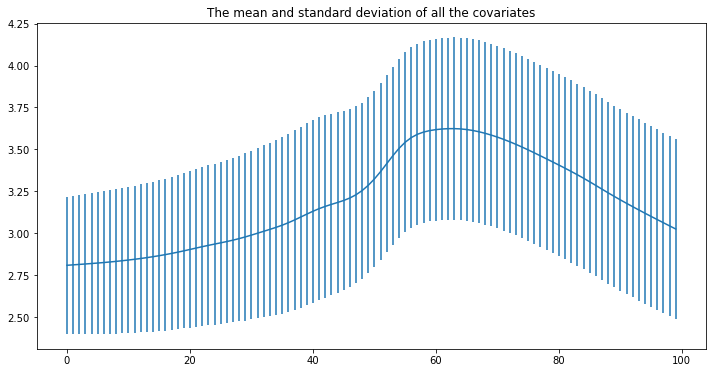

In [6]:
n, p = df.shape
for i in range(p) :
    df[i] = pd.to_numeric(df[i], errors='coerce') # to convert the type of the data to numeric
    
# In order to get the mean and std of the covariates, we need to remove the column 'fat'
means = np.array(df.iloc[:, :p-1]).mean(axis=0, dtype=np.float64) 
stds = np.array(df.iloc[:, :p-1]).std(axis=0, dtype=np.float64)

plt.figure(figsize = (12, 6))
plt.errorbar(np.arange(p-1), means, stds)
plt.title("The mean and standard deviation of all the covariates")

It's clear that the data is :

1.*Not centered*, since the mean is not 0.

2.*Not normalized*, since it has values out of the segment [0, 1]. 

3.*Not standarized* since it's not centered (and also the standard deviation is not 1).

In [7]:
X = np.array(df.iloc[:, :p-1])
Y = np.array(df[100]) # The variable that we seek to predict its value : fat

# Separating the data into train and test sets 
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.25, train_size = 0.75)

# Standarazing both training and testing sets

scaler = StandardScaler()
# The test set must use identical scaling to the training set
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#Use only the training set to calculate the mean and variance, standarize the training set, and then at test time,
#use that same (training) mean and variance to normalize the test set
Y_train = scaler.fit_transform(Y_train.reshape(-1, 1))
Y_test = scaler.transform(Y_test.reshape(-1, 1))

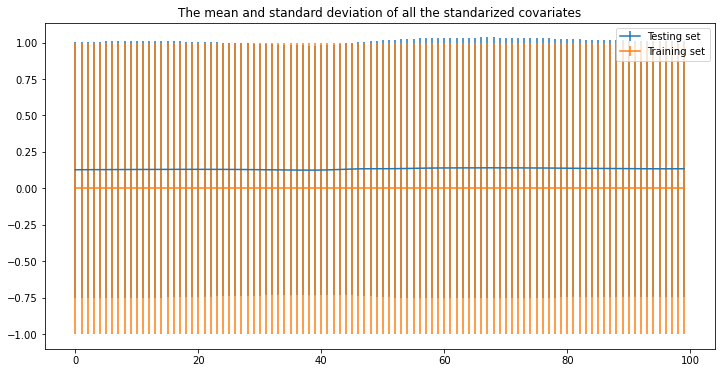

In [8]:
standard_means_train = np.array(X_train).mean(axis=0, dtype=np.float64) 
standard_stds_train = np.array(X_train).std(axis=0, dtype=np.float64)

standard_means_test = np.array(X_test).mean(axis=0, dtype=np.float64) 
standard_stds_test = np.array(X_test).std(axis=0, dtype=np.float64)

plt.figure(figsize = (12, 6))
plt.errorbar(np.arange(p-1), standard_means_test, standard_stds_test, label = 'Testing set')
plt.errorbar(np.arange(p-1), standard_means_train, standard_stds_train, label = 'Training set')
plt.title("The mean and standard deviation of all the standarized covariates")
plt.legend()

In [9]:
def r_2(Y_predicted, Y_groud_truth) :
    
    Y_predicted = Y_predicted.flatten()
    Y_groud_truth = Y_groud_truth.flatten()
    Y_bar = np.mean(Y_groud_truth)
    return 1 - np.linalg.norm(Y_predicted - Y_groud_truth)**2 / np.linalg.norm(Y_groud_truth - np.mean(Y_groud_truth))**2

In [10]:
# Fitting a regular OLS

# We don't have to fit the intercpt since we hav already standarized the data
regression = LinearRegression(fit_intercept = False)
attributes = regression.fit(X_train, Y_train) 

In [11]:
Y_predicted = attributes.predict(X_test)
r2_OLS = r_2(Y_predicted, Y_test)
df_coef = pd.DataFrame({'Regular OLS' : [r2_OLS]})
print(r2_OLS)

0.9600547777979198


#### Variable selection :
##### Q2 :

In [12]:
def f_variable_selection(X, Y, p_stop = None, stop_cirterion = False) :
    
    ''' Performs forward variable selection on the training input data X and training output data Y
        Returns a list containing the selected variables in order
    '''
    n, p = X.shape
    S = [] # To store all the variables, in their order of 'importance'
    S_stop = [] # To store all the variables with a p-value smaller than p_stop
    r = Y
    p_values = []
    
    reg = LinearRegression(fit_intercept = False)
    
    while len(S) < p : # Since we don't define a stop criterion
        T = {}
        Thetas = {}
        for k in range(p) :
            if k not in S :
                X_ = np.stack((np.ones(n), X[:, k]), axis = 1)
                reg.fit(X_, r)
                theta_hat = reg.coef_.T
                Gram_hat = X_.T @ X_ / n
                s_hat = np.sqrt(np.linalg.inv(Gram_hat)[0][0])
                sigma_hat = np.linalg.norm(r - X_ @ theta_hat)**2 / (n-2)
                T_hat = (np.sqrt(n)*np.linalg.norm(theta_hat, 1)) / (s_hat * sigma_hat)
                T[k] = T_hat
                Thetas[k] = theta_hat
        k_star = max(T, key = T.get)
        p_value = 2*(1 - scipy.stats.norm.cdf(T[k_star]))
        if stop_cirterion :
            if p_value < p_stop : S_stop.append(k_star)
        p_values.append(p_value)
        S.append(k_star)
        r = r - np.stack((np.ones(n), X[:, k_star]), axis = 1) @ Thetas[k_star]
    
    return S, p_values, S_stop

In [13]:
S = f_variable_selection(X_train, Y_train)[0]
p_values = f_variable_selection(X_train, Y_train)[1]
print(f"The selected variables are, in their selection order : {S}")

The selected variables are, in their selection order : [40, 7, 39, 6, 41, 8, 38, 5, 42, 9, 37, 4, 36, 10, 97, 3, 43, 11, 35, 2, 96, 12, 98, 13, 34, 1, 44, 0, 95, 14, 33, 15, 99, 16, 32, 17, 94, 18, 93, 19, 45, 64, 31, 65, 92, 63, 91, 66, 90, 67, 30, 20, 89, 62, 88, 68, 46, 61, 87, 69, 86, 60, 85, 53, 29, 52, 84, 70, 83, 54, 28, 59, 82, 21, 47, 55, 81, 58, 27, 51, 80, 71, 26, 56, 79, 57, 48, 72, 78, 50, 25, 22, 77, 73, 24, 74, 76, 75, 49, 23]


##### Q3 :

In [14]:
# Keeping the selected variables in both train and test sets
S_stop = f_variable_selection(X_train, Y_train, 0.05, stop_cirterion=True)[2]
X_selected_train = []
X_selected_test = []
for k in range(len(S_stop)) :
    X_selected_train.append(X_train[:, S_stop[k]])
    X_selected_test.append(X_test[:, S_stop[k]])
    
X_selected_train = np.array(X_selected_train).T
X_selected_test = np.array(X_selected_test).T

# Applying the OLS with the selected vairables 
variable_selection_reg = LinearRegression(fit_intercept=False)
variable_selection_reg.fit(X_selected_train, Y_train)
Y_predicted_vs = variable_selection_reg.predict(X_selected_test)

# Storing the R² coefficient in the data frame
r2_variable_selection = r_2(Y_predicted_vs, Y_test)
df_coef["Forward variable selection"] = r2_variable_selection
print(len(S_stop))

23


In [15]:
sfs = SequentialFeatureSelector(estimator = LinearRegression(fit_intercept=False), n_features_to_select=len(S_stop))
sfs.fit(X_train, Y_train)

SequentialFeatureSelector(estimator=LinearRegression(fit_intercept=False),
                          n_features_to_select=23)

In [16]:
support = sfs.support_
sequential_selected = []
for k in range(len(support)) :
    if support[k] == True : sequential_selected.append(k)
print(f"The sequentially selected variables are :  {sequential_selected}")
print(f"The forward selected variables are : {S_stop}")

The sequentially selected variables are :  [0, 1, 3, 18, 19, 21, 34, 35, 39, 40, 43, 46, 47, 48, 49, 57, 72, 74, 82, 87, 90, 97, 99]
The forward selected variables are : [40, 7, 39, 6, 41, 8, 38, 5, 42, 9, 37, 4, 36, 10, 97, 3, 43, 11, 35, 2, 96, 12, 98]


In [17]:
r2_sequential = r_2(Y_predicted_vs, Y_test)
print(r2_sequential)
df_coef["Sequential variable selection"] = r2_sequential

0.9551797946009011


#### Ridge :

In [18]:
def ridge(X, Y, alpha) :
    n, p = X.shape
    G = X.T @ X
    I = np.eye(p, p)
    theta_hat = np.dot(np.linalg.inv(n*alpha * I + G) @ X.T, Y)
    
    return theta_hat

Text(0.5, 1.0, 'The values of ridge coefficients as a function of $\\alpha$')

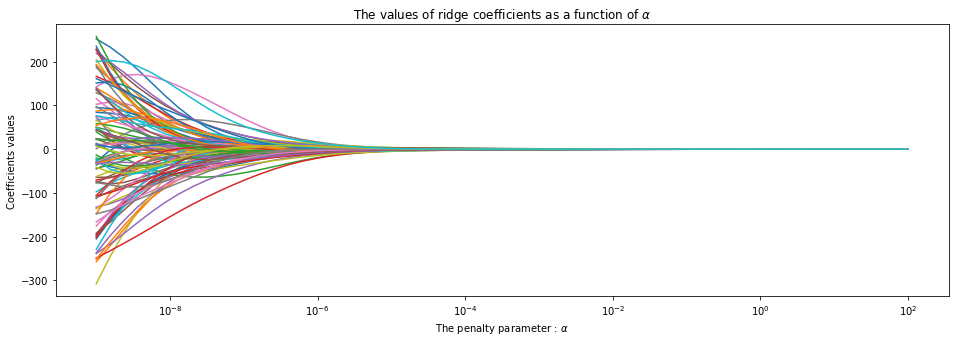

In [19]:
# How the coefficients change with alpha

n_alphas = 60
plot_alphas = np.logspace(-9, 2, num=n_alphas)
#plot_alphas = np.arange(10e-2, 10e2)

fig = plt.figure(figsize=(16,5))

for i in range(p-1) : # The i-th coefficient of theta_hat
    Theta_i = []
    for k in range(len(plot_alphas)) :
        Theta_i.append(ridge(X_train, Y_train, plot_alphas[k])[i])
    plt.plot(plot_alphas, Theta_i)

plt.xlabel(r"The penalty parameter : $\alpha$")
plt.ylabel("Coefficients values")
plt.xscale('log')
plt.title(r"The values of ridge coefficients as a function of $\alpha$")

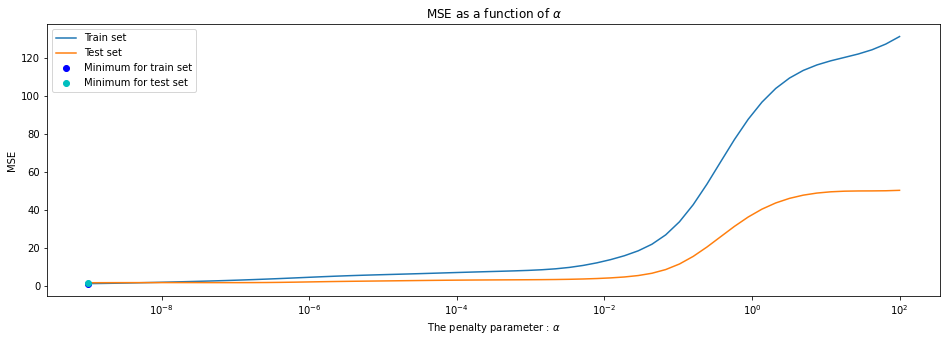

In [20]:
# MSE of both train and test sets

n_alphas = 60
alphas = np.logspace(-9, 2, num=n_alphas)

#alphas = np.arange(10e-9, 10e2)

MSE_train = []
MSE_test = []
min_train = len(alphas) + 1
min_test = len(alphas) + 1

for k in range(len(alphas)) :
    theta_hat = ridge(X_train, Y_train, alphas[k])
    Y_train_hat = X_train @ theta_hat
    Y_test_hat = X_test @ theta_hat
    err_train = np.linalg.norm(Y_train_hat - Y_train, 2)**2
    err_test = np.linalg.norm(Y_test_hat - Y_test, 2)**2
    if  err_train < min_train : min_train = k
    if err_test < min_test : min_test = k
    MSE_train.append(err_train)
    MSE_test.append(err_test)
    
fig = plt.figure(figsize=(16,5))
plt.plot(alphas, MSE_train, label = 'Train set')
plt.plot(alphas, MSE_test, label = 'Test set')
plt.plot(alphas[min_train], MSE_train[min_train], 'bo', label = 'Minimum for train set')
plt.plot(alphas[min_train], MSE_test[min_train], 'co', label = 'Minimum for test set')
plt.xlabel(r"The penalty parameter : $\alpha$")
plt.ylabel("MSE")
plt.xscale('log')
plt.title(r"MSE as a function of $\alpha$")
plt.legend()

In [21]:
# Choosing the best performing value of alpha 

alpha_best = alphas[min_train]
theta_ridge = ridge(X_train, Y_train, alpha_best)
Y_predicted_ridge = X_test @ theta_ridge
r2_ridge = r_2(Y_predicted_ridge, Y_test)
df_coef["Ridge"] = r2_ridge
df_coef

,Regular OLS,Forward variable selection,Sequential variable selection,Ridge
0,0.960055,0.95518,0.95518,0.968269


#### Crossvalidation, Lasso and elastic net :

In [22]:
n_alphas = 30
lasso_alphas = np.logspace(-5, -2, num=n_alphas)

thetas_nz = []

MSE_train_lasso = []
MSE_test_lasso = []

for k in range(len(lasso_alphas)) :
    lasso_k = Lasso(lasso_alphas[k], fit_intercept = False, max_iter = 10e4, tol=10e-5)
    lasso_k.fit(X_train, Y_train)
    theta_hat = lasso_k.coef_
    
    count_nz = 0
    for t in theta_hat:
        if t != 0 : count_nz += 1
    thetas_nz.append(count_nz)
   
    Y_train_pred = lasso_k.predict(X_train)
    Y_test_pred = lasso_k.predict(X_test)
    err_train = np.mean((Y_train_pred - Y_train)**2)
    err_test = np.mean((Y_test_pred - Y_test)**2)
    MSE_train_lasso.append(err_train)
    MSE_test_lasso.append(err_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.759e+00, tolerance: 1.610e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e+00, tolerance: 1.610e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.407e+00, toleranc

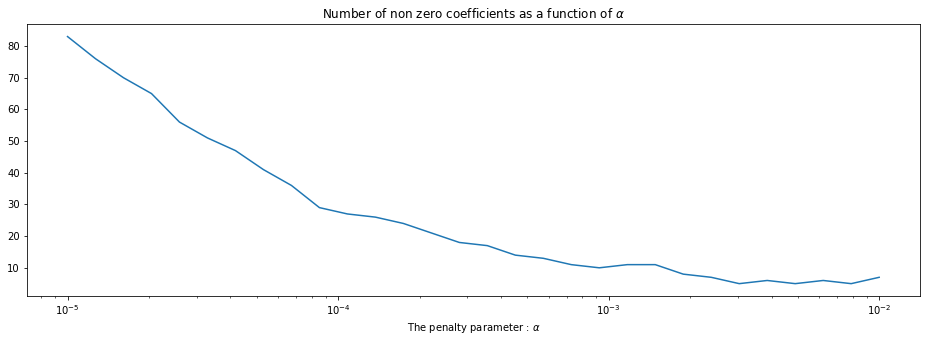

In [23]:
fig = plt.figure(figsize=(16,5))

plt.plot(lasso_alphas, thetas_nz)
plt.xlabel(r"The penalty parameter : $\alpha$")
plt.title(r"Number of non zero coefficients as a function of $\alpha$")
plt.xscale('log')

2.0295104324054165
1.712674048726447


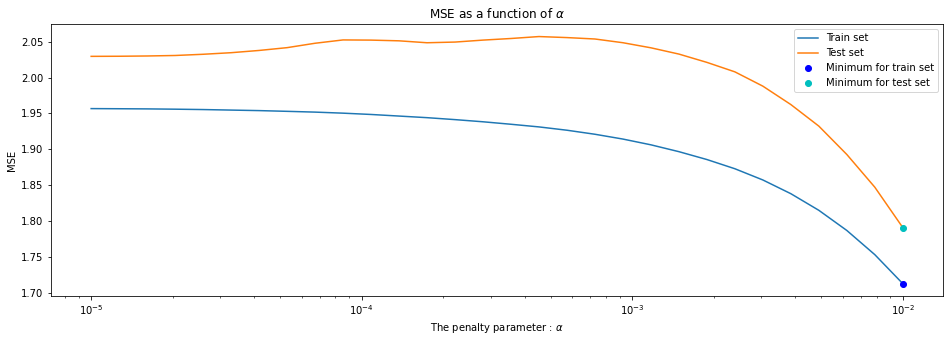

In [24]:
min_train_lasso = min(MSE_train_lasso)
min_test_lasso = min(MSE_test_lasso)

print(MSE_test_lasso[0])
print(MSE_train_lasso[len(MSE_train_lasso)-1])

fig = plt.figure(figsize=(16,5))
plt.plot(lasso_alphas, MSE_train_lasso, label = 'Train set')
plt.plot(lasso_alphas, MSE_test_lasso, label = 'Test set')
plt.plot(lasso_alphas[MSE_train_lasso.index(min_train_lasso)], min_train_lasso, 'bo', label = 'Minimum for train set')
plt.plot(lasso_alphas[MSE_test_lasso.index(min_test_lasso)], min_test_lasso, 'co', label = 'Minimum for test set')
plt.xlabel(r"The penalty parameter : $\alpha$")
plt.ylabel("MSE")
plt.xscale('log')
plt.title(r"MSE as a function of $\alpha$")
plt.legend()

In [25]:
alpha_lasso = lasso_alphas[MSE_train_lasso.index(min_train_lasso)]
lasso_k = Lasso(alpha_lasso, fit_intercept = False, max_iter = 10e4, tol=10e-5)
lasso_k.fit(X_train, Y_train)
theta_lasso = lasso_k.coef_
Y_predicted_lasso = X_test @ theta_lasso
r2_lasso = r_2(Y_predicted_lasso, Y_test)
df_coef["Lasso"] = r2_lasso
df_coef

,Regular OLS,Forward variable selection,Sequential variable selection,Ridge,Lasso
0,0.960055,0.95518,0.95518,0.968269,0.903089


In [119]:
# Cross validation

'''K = 10
r = 30
    
X_folds = np.zeros((X_train.shape[0], X_train.shape[1]))
Y_folds = []

for k in range(K) :
    if k == 0 : 
        X_folds[] = np.concatenate((X_folds, X_train[k:k+len(X_train)//K + 1]), axis=1)
        Y_folds = np.concatenate((Y_folds, Y_train[k:k+len(X_train)//K + 1]), axis=1)
    else : 
        X_folds = np.concatenate((X_folds, X_train[k:k+len(X_train)//K]), axis=1)
        Y_folds = np.concatenate((Y_folds, Y_train[k:k+len(X_train)//K]), axis=1)'''
print(X_train.shape[0])

161


In [124]:
cv_ridge_alphas = np.logspace(-10, 3, r)
cv_lasso_alphas = [0, 0.1, 0.5, 0.7, 0.9, 0.99]


Errors = []
for a_lasso in cv_lasso_alphas :
    Errors_ridge = []
    for a_ridge in cv_ridge_alphas :
        Errors_k = []
        for k in range(K) : 
            delta = len(X_train)//K
            if k == 0 :
                indices = range(0, delta + 1)
                #Y_cv_test = Y_train[k:k+len(X_train)//K + 1]
            else :
                indices = range(k*delta + 1, (k+1)*delta)
                #Y_cv_test = Y_train[k:k+len(X_train)//K]
            X_cv_k = np.reshape(np.delete(X_train, indices), ((K-1)*len(indices), X_train.shape[1]))
            Y_cv_k = np.delete(Y_train, indices)
            
            elastic_net = ElasticNet(alpha = a_lasso + a_ridge, l1_ratio = a_lasso/(a_lasso + a_ridge), 
                                     fit_intercept = False, max_iter = 10e4, tol = 10e-4)
            elastic_net.fit(X_cv_k, Y_cv_k)
            theta_cv_k = elastic_net.coef_
            Y_cv_pred = elastic_net.predict(X_train[indices])
            err = np.mean((Y_cv_pred - Y_train[indices])**2)
            Errors_k.append(err)
        Errors_ridge.append(np.mean(Errors_k))
    Errors_lasso.append(Errors_ridge)

ValueError: cannot reshape array of size 16083 into shape (153,100)